# **Nettoyage des données**

Fichier .csv téléchargé le 24 octobre 2021.

https://world.openfoodfacts.org/data

Première exploration et nettoyage des données du Projet 2 "Concevez une application au service de la santé publique".

https://openclassrooms.com/fr/paths/148/projects/628/assignment

https://world.openfoodfacts.org/data/data-fields.txt

## Idée d'application
Recommandation de boissons similaires et/ou avec de meilleurs caractéristiques


In [ ]:
# Connecte le notebook Colab à Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import de librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Chargement du dataset
gdrive_path = 'drive/MyDrive/PSanté/en.openfoodfacts.org.products.csv'
raw_data = pd.read_csv(gdrive_path, sep='\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,8,13,19,20,21,22,23,27,28,29,31,52,55,64) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Premier coup d'oeil

In [ ]:
# Rapide coup d'oeil au dataset
raw_data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998448 entries, 0 to 1998447
Data columns (total 187 columns):
 #   Column                                                 Non-Null Count    Dtype  
---  ------                                                 --------------    -----  
 0   code                                                   1998448 non-null  object 
 1   url                                                    1998448 non-null  object 
 2   creator                                                1998444 non-null  object 
 3   created_t                                              1998448 non-null  int64  
 4   created_datetime                                       1998448 non-null  object 
 5   last_modified_t                                        1998448 non-null  int64  
 6   last_modified_datetime                                 1998448 non-null  object 
 7   product_name                                           1916569 non-null  object 
 8   abbreviated_product_n

In [ ]:
# Rapide coup d'oeil sur les premières lignes du dataset
raw_data.head(10)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,...,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,NaN,NaN,NaN,NaN,endives,endives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:france,en:france,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1630483911,2021-09-01T08:11:51Z,1630484064,2021-09-01T08:14:24Z,L.casei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,"Leche semidesnatada, azucar 6.9% leche desnata...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,NaN,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1624390765,2021-06-22T19:39:25Z,Filetes de pollo empanado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Espagne,en:spain,Spain,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,000000000004622327,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1619501895,2021-04-27T05:38:15Z,1619501897,2021-04-27T05:38:17Z,Hamburguesas de ternera 100%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:es,en:spain,Spain,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

- Le dataset est très éparse
- Peu de mauvais Dtype à première vue (variables continues en float64, catégorielles et tags en object)
  
  -> Sauf nova_group à passer en categorielle
 
  -> sauf les variables temporelles qui sont en object ou int64, mais nous n'allons pas les utiliser.




In [ ]:
# Passe nova_group en var catégorielle
raw_data['nova_group'] = raw_data['nova_group'].astype('object')

In [ ]:
inst = {'étape': ['import'], 'n colonnes': [raw_data.shape[1]], 'n lignes': [raw_data.shape[0]] , '% lignes del': [0], '% lignes restantes': [raw_data.shape[0]/raw_data.shape[0]]}

df_stats = pd.DataFrame.from_dict(inst)

In [ ]:
# Fonction qui track les suppressions de lignes et colonnes

def clean_step(étape):
   
  global df_stats
  
  lignes_del = ((df_stats.iloc[-1, 2]-raw_data.shape[0])/df_stats.iloc[-1, 2])*100
 
  lignes_rest = (raw_data.shape[0]/df_stats.iloc[0, 2])*100

  n_row = {'étape': [étape], 'n colonnes': [raw_data.shape[1]], 'n lignes': [raw_data.shape[0]] , '% lignes del': [lignes_del], '% lignes restantes': [lignes_rest]}
  
  new_row = pd.DataFrame.from_dict(n_row)

  df_stats = df_stats.append(new_row, ignore_index=True)

  new_row

  return df_stats


## Filtrage par pays; France

Je choisi de me concentrer sur la France (produits vendus en France):
- C'est le pays avec le plus de données disponibles (cf. site web d'OFF, environ 850000 produits renseignés à la vente en France) 
- le dataset étant volumineux, réduire sa taille me permettra de le travailler plus facilement (e.g. gérer les tags, plots pour regarder les queues de distribution, boxplot pour valeurs abérantes, )

In [ ]:
# Rapide coup d'oeil sur la colonne utilisée pour filtrer par pays
raw_data['countries_en'].unique()[:400]

array(['France', 'Spain', 'United States', 'Ireland', nan, 'Belgium',
       'United Kingdom', 'France,United States', "Côte d'Ivoire",
       'Canada', 'Switzerland', 'Italy', 'Germany', 'Belgium,France',
       'Peru', 'Oman', 'Slovenia', 'France,Germany',
       'France,Germany,Netherlands', 'Kuwait', 'United Arab Emirates',
       'France,Switzerland', 'Romania', 'Australia', 'Norway',
       'Luxembourg', 'Portugal', 'Mexico', 'Dominican Republic',
       'Réunion', 'Israel', 'Netherlands', 'Saudi Arabia', 'Poland',
       'Germany,United States', 'Germany,Ireland', 'Rwanda',
       'France,United Kingdom',
       'Belgium,France,Netherlands,United Kingdom', 'Guadeloupe', 'Chile',
       'Thailand', 'El Salvador', 'Algeria', 'Greece',
       'Spain,Switzerland', 'France,Russia', 'France,India',
       'Austria,Frankreich,Spanien', 'Senegal',
       'United Kingdom,United States', 'Andorra', 'Austria,France',
       'Germany,Luxembourg,Spain', 'Lithuania', 'Germany,Spain', 'Jersey'


"France" est nommée dans plusieurs autres langues (e.g "Frankreich")


On recherche la présence des patterns suivants dans countries_en: 
France|Frankreich|Francia|França|франция|Francia|Frankrijk|Francja|Franţa|Fransa|франція|Frankrijk|γαλλία|Γαλλία|Gallia|Francuska|Francúzsko|Francie|Frakkland

In [ ]:
# filtre France dans multiples langues
# filtre non sensible aux majuscules
raw_data = raw_data[raw_data["countries_en"].str.contains("France|Frankreich|Francia|França|франция|Francia|Frankrijk|Francja|Franţa|Fransa|франція|Frankrijk|γαλλία|Γαλλία|Gallia|Francuska|Francúzsko|Francie|Frakkland", na = False, case=False)]

In [ ]:
# Statistiques sur les nombre de lignes et colonnes à cette étapes du nettoyage
clean_step('filtre sur la France')

,étape,n colonnes,n lignes,% lignes del,% lignes restantes
0,import,187,1998448,0.000000,1.000000
1,filtre sur la France,187,847601,57.587038,42.412962


## Filtrage par catégorie; boisson

In [ ]:
# Filtre les boissons
raw_data = raw_data[(raw_data['pnns_groups_1'] == 'Beverages') | (raw_data['pnns_groups_2'] == 'Alcoholic beverages')]

raw_data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40114 entries, 66 to 1998330
Data columns (total 187 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   code                                                   40114 non-null  object 
 1   url                                                    40114 non-null  object 
 2   creator                                                40114 non-null  object 
 3   created_t                                              40114 non-null  int64  
 4   created_datetime                                       40114 non-null  object 
 5   last_modified_t                                        40114 non-null  int64  
 6   last_modified_datetime                                 40114 non-null  object 
 7   product_name                                           39770 non-null  object 
 8   abbreviated_product_name                  

In [ ]:
# Statistiques sur les nombre de lignes et colonnes à cette étapes du nettoyage
clean_step('sélection des boissons')


,étape,n colonnes,n lignes,% lignes del,% lignes restantes
0,import,187,1998448,0.000000,1.000000
1,filtre sur la France,187,847601,57.587038,42.412962
2,sélection des boissons,187,40114,95.267349,2.007258


## Suppression des colonnes vides

In [ ]:
# Supprime les colonnes vides (principalement des sous-catégories d'un ingrédient e.g. sucre)
raw_data.dropna(axis = 1, how = 'all', inplace=True)
raw_data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40114 entries, 66 to 1998330
Data columns (total 139 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   code                                                   40114 non-null  object 
 1   url                                                    40114 non-null  object 
 2   creator                                                40114 non-null  object 
 3   created_t                                              40114 non-null  int64  
 4   created_datetime                                       40114 non-null  object 
 5   last_modified_t                                        40114 non-null  int64  
 6   last_modified_datetime                                 40114 non-null  object 
 7   product_name                                           39770 non-null  object 
 8   abbreviated_product_name                  

In [ ]:
# Statistiques sur les nombre de lignes et colonnes à cette étapes du nettoyage
clean_step('suppression des colonnes vides')

,étape,n colonnes,n lignes,% lignes del,% lignes restantes
0,import,187,1998448,0.000000,1.000000
1,filtre sur la France,187,847601,57.587038,42.412962
2,sélection des boissons,187,40114,95.267349,2.007258
3,suppression des colonnes vides,139,40114,0.000000,2.007258


## Suppression des lignes n'ayant pas de nutrition facts

In [ ]:
# liste des colonnes se terminant par _100g
nutrition_facts = list(raw_data.columns[raw_data.columns.str.endswith('_100g') == True])

# Print le nombre de lignes sans nutrition facts
print('Lignes sans nutrition facts:', raw_data[nutrition_facts].isnull().all(axis=1).sum())

# Drop les lignes sans nutrition facts
raw_data = raw_data.dropna(subset=nutrition_facts, how='all')

raw_data.info(verbose=True, null_counts=True)

Lignes sans nutrition facts: 5784
<class 'pandas.core.frame.DataFrame'>
Int64Index: 34330 entries, 66 to 1998330
Data columns (total 139 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   code                                                   34330 non-null  object 
 1   url                                                    34330 non-null  object 
 2   creator                                                34330 non-null  object 
 3   created_t                                              34330 non-null  int64  
 4   created_datetime                                       34330 non-null  object 
 5   last_modified_t                                        34330 non-null  int64  
 6   last_modified_datetime                                 34330 non-null  object 
 7   product_name                                           34160 non-null  object 
 8   abbrevia

In [ ]:
# Statistiques sur les nombre de lignes et colonnes à cette étapes du nettoyage
clean_step('suppression des lignes sans nutrition facts')

,étape,n colonnes,n lignes,% lignes del,% lignes restantes
0,import,187,1998448,0.000000,1.000000
1,filtre sur la France,187,847601,57.587038,42.412962
2,sélection des boissons,187,40114,95.267349,2.007258
3,suppression des colonnes vides,139,40114,0.000000,2.007258
4,suppression des lignes sans nutrition facts,139,34330,14.418906,1.717833


## Suppression des lignes sans nom de produit

In [ ]:
# Suppression des lignes sans nom de produit
raw_data = raw_data.dropna(subset=['product_name'])
raw_data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34160 entries, 66 to 1998330
Data columns (total 139 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   code                                                   34160 non-null  object 
 1   url                                                    34160 non-null  object 
 2   creator                                                34160 non-null  object 
 3   created_t                                              34160 non-null  int64  
 4   created_datetime                                       34160 non-null  object 
 5   last_modified_t                                        34160 non-null  int64  
 6   last_modified_datetime                                 34160 non-null  object 
 7   product_name                                           34160 non-null  object 
 8   abbreviated_product_name                  

In [ ]:
# Statistiques sur les nombre de lignes et colonnes à cette étapes du nettoyage
clean_step('suppression des lignes sans nom de produit')

,étape,n colonnes,n lignes,% lignes del,% lignes restantes
0,import,187,1998448,0.000000,1.000000
1,filtre sur la France,187,847601,57.587038,42.412962
2,sélection des boissons,187,40114,95.267349,2.007258
3,suppression des colonnes vides,139,40114,0.000000,2.007258
4,suppression des lignes sans nutrition facts,139,34330,14.418906,1.717833
5,suppression des lignes sans nom de produit,139,34160,0.495194,1.709326


## Doublons (et quasi-doublons)

In [ ]:
# Calcul du nombre de doublons
print("toutes les colonnes identiques : ", raw_data.duplicated().sum())
print("code : ", raw_data["code"].duplicated().sum())
print("product_name : ", raw_data["product_name"].duplicated().sum())

toutes les colonnes identiques :  0
code :  2
product_name :  8649


**Il y'a beaucoup de produits ayant le même nom. Il est cependant possible que plusieurs produits aient le même nom, mais une quantité ou un packaging différent. Il est également possible que ces produits soient de marques différentes.**

In [ ]:
# Drop des doublons ayant le même code
raw_data = raw_data.drop_duplicates('code',keep='first')

In [ ]:
# Doublons sur plusieures colonnes
print("doublons sur nom du produit, quantité, packaging et marque : ", raw_data.duplicated(subset=['product_name','quantity', 'packaging', 'brands']).sum())

doublons sur nom du produit, quantité, packaging et marque :  1553


In [ ]:
# tri le dataset par nombre de valeurs manquantes descendantes puis date de modification ascendantes
raw_data['null_count'] = raw_data.isnull().sum(axis=1)
raw_data = raw_data.sort_values(['null_count', 'last_modified_t'], ascending=(False, False)).drop('null_count', axis=1)

# suppression des doublons
raw_data = raw_data.drop_duplicates(subset=['product_name','quantity', 'packaging', 'brands'], keep='first')

In [ ]:
# Statistiques sur les nombre de lignes et colonnes à cette étapes du nettoyage
clean_step('suppression des doublons')

,étape,n colonnes,n lignes,% lignes del,% lignes restantes
0,import,187,1998448,0.000000,1.000000
1,filtre sur la France,187,847601,57.587038,42.412962
2,sélection des boissons,187,40114,95.267349,2.007258
3,suppression des colonnes vides,139,40114,0.000000,2.007258
4,suppression des lignes sans nutrition facts,139,34330,14.418906,1.717833
5,suppression des lignes sans nom de produit,139,34160,0.495194,1.709326
6,suppression des doublons,139,32605,4.552108,1.631516


## Plus d'informations sur certaines variables et drop





### Variables non présentes dans la description du dataset

Plusieurs variables sont présentes dans le dataset, mais ne sont pas listées dans le descriptif suivant: https://world.openfoodfacts.org/data/data-fields.txt

.


-  packaging_text-----> peu de valeurs, difficilement exploitable, on supprime

-  allergens-----> nom explicite, on garde


-  traces_en-----> semble être une variante de trace et trace_tags

-   serving_quantity-----> nom explicite, on garde

-   nova_group-----> on garde, cf. https://world.openfoodfacts.org/nova

-  pnns_groups_1-----> on garde, cf. https://www.dietetique-paris.fr/index.php/actualites-mainmenu/a-la-une-mainmenu/170-pnns-1-et-pnns-2

-  pnns_groups_2-----> on garde, cf. https://www.dietetique-paris.fr/index.php/actualites-mainmenu/a-la-une-mainmenu/170-pnns-1-et-pnns-2

-  states

-  states_tags

-  states_en-----> Variante des deux variable précédentes.donne diverses informations sur l'état de completion du produit. on garde pour l'instant.

-  brand_owner-----> Explicite, marque du broduit, on garde pour l'instant

-  ecoscore_score_fr-----> -15 à +20, cf. https://etiquettable.eco2initiative.com/accueil/ecoscore/

-  ecoscore_grade_fr-----> cf. https://etiquettable.eco2initiative.com/accueil/ecoscore/

-  image_nutrition_url-----> image, on ne garde pas

-  image_nutrition_small_url-----> image, on ne garde pas

-  energy-from-fat_100g-----> trop peu de données, on ne garde pas

- fruits-vegetables-nuts-dried_100g-----> trop peu de données et redondance avec une autre variable, on ne garde pas

- fruits-vegetables-nuts-estimate_100g-----> trop peu de données et redondance avec une autre variable, on ne garde pas

- fruits-vegetables-nuts-estimate-from-ingredients_100g-----> explicite, intéressant et assez complet, on garde

- carbon-footprint-from-meat-or-fish_100g-----> intéressant mais trop peu de données, on ne garde pas

- glycemic-index_100g-----> intéressant mais trop peu de données, on ne garde pas

- water-hardness_100g-----> intéressant mais trop peu de données, on ne garde pas

- choline_100g                                           66 non-null       float64

- phylloquinone_100g                                     1712 non-null     float64

- beta-glucan_100g                                       38 non-null       float64

- inositol_100g                                          69 non-null       float64

- carnitine_100g                                         39 non-null       float64

.

------------ > On garde les 5 derniers_100g pour l'instant

In [ ]:
# drop de la selection de colonnes hors-descriptif du dataset
raw_data = raw_data.drop(['packaging_text', 'energy-from-fat_100g', 'fruits-vegetables-nuts-dried_100g', 'fruits-vegetables-nuts-estimate_100g', 'carbon-footprint-from-meat-or-fish_100g'], axis = 1)

### Colonnes non utilisées

On supprime plusieurs types de colonnes qui ne seront pas utilisées dans la suite de ce projet:    
- les variables temporelles (sauf date de création)
- les liens (vers le produit, vers des images)
- plusieurs colonnes relatives au nom du produit (on garde la plus complète)
- carbon-footprint_100g qui n'est pas un composé alimentaire et peu complet

In [ ]:
# drop d'une selection de colonnes
raw_data = raw_data.drop(['url', 'creator', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'abbreviated_product_name', 'generic_name', 'image_url', 'image_small_url', 'image_ingredients_url', 'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url', 'carbon-footprint_100g'], axis = 1)

### Colonnes similaires

Certaines variables contiennent des informations similaires, ce qui va nous permettre d'en supprimer en fonction de leur exploitabilité et du nombre de NaNs.



In [ ]:
 #11  packaging                                              310080 non-null   object +
 #12  packaging_tags                                         310045 non-null   object 
 #13  packaging_text                                         7365 non-null     object 
print(raw_data['packaging'].unique()[:5])
print(raw_data['packaging_tags'].unique()[:5])

[nan 'fr:Bouteille en verre' 'Bouteille,Verre' 'bouteille' 'verre']
[nan 'fr-bouteille-en-verre' 'bouteille,verre' 'bouteille' 'verre']


In [ ]:
# On garde packaging car - de NaNs
raw_data = raw_data.drop(['packaging_tags'], axis = 1)

In [ ]:
#58  brand_owner                                            290011 non-null   object 
#14  brands                                                 1030813 non-null  object +
#15  brands_tags                                            1030744 non-null  object 
print(raw_data['brand_owner'].unique()[:5])
print(raw_data['brands'].unique()[:5])
print(raw_data['brands_tags'].unique()[:5])

[nan 'LOV ORGANIC' 'ILLY' 'Whole Foods Market, Inc.' 'CLOVER VALLEY']
[nan 'clan corrigeant Spice' 'La benaise ambree' 'Pineau'
 'Pineau de Charentes Natol']
[nan 'clan-corrigeant-spice' 'la-benaise-ambree' 'pineau'
 'pineau-de-charentes-natol']


In [ ]:
# On garde brands car - de NaNs et brand_owner car différente variable
raw_data = raw_data.drop(['brands_tags'], axis = 1)

In [ ]:
# 16  categories                                             931842 non-null   object +
# 17  categories_tags                                        931836 non-null   object
# 18  categories_en                                          931836 non-null   object 
print(raw_data['categories'].unique()[:5])
print(raw_data['categories_tags'].unique()[:5])
print(raw_data['categories_en'].unique()[:5])

['Boissons, Boissons alcoolisées, Vins' 'en:wines' 'Vin de Savoie'
 "Vin d'espagne" 'fr:Bière blonde']
['en:beverages,en:alcoholic-beverages,en:wines'
 'en:beverages,en:alcoholic-beverages,en:wines,en:wines-from-france,fr:vin-de-savoie'
 'en:beverages,en:alcoholic-beverages,en:wines,en:wines-from-spain'
 'en:beverages,en:alcoholic-beverages,en:beers,en:lagers'
 'en:beverages,en:alcoholic-beverages']
['Beverages,Alcoholic beverages,Wines'
 'Beverages,Alcoholic beverages,Wines,Wines from France,fr:Vin de Savoie'
 'Beverages,Alcoholic beverages,Wines,Wines from Spain'
 'Beverages,Alcoholic beverages,Beers,Lagers'
 'Beverages,Alcoholic beverages']


In [ ]:
# On garde categories_en car var probablement processed sur _tags traduit de toutes les langues vers EN, + constant
raw_data = raw_data.drop(['categories_tags', 'categories'], axis = 1)

In [ ]:
 #19  origins                                                85876 non-null    object +
 #20  origins_tags                                           85747 non-null    object 
 #21  origins_en                                             85747 non-null    object 
print(raw_data['origins'].unique()[:5])
print(raw_data['origins_tags'].unique()[:5])
print(raw_data['origins_en'].unique()[:5])

[nan 'France' 'Coteau du Pont du Gard'
 'Parc naturel régional du ballon des Vosges' 'Japon']
[nan 'en:france' 'fr:coteau-du-pont-du-gard'
 'en:parc-naturel-regional-du-ballon-des-vosges' 'en:japan']
[nan 'France' 'fr:coteau-du-pont-du-gard'
 'Parc-naturel-regional-du-ballon-des-vosges' 'Japan']


In [ ]:
# On garde origins_en car var probablement processed sur _tags traduit de toutes les langues vers EN
raw_data = raw_data.drop(['origins', 'origins_tags'], axis = 1)

In [ ]:
 # 22  manufacturing_places                                   125553 non-null   object +
 # 23  manufacturing_places_tags                              125495 non-null   object 
print(raw_data['manufacturing_places'].unique()[:5])
print(raw_data['manufacturing_places_tags'].unique()[:5])

[nan 'Mexico' 'Fougerolles'
 'Via Peter Anich  7  39011 Zona Industriale Artigianale (BZ)' 'Germany']
[nan 'mexico' 'fougerolles'
 'via-peter-anich-7-39011-zona-industriale-artigianale-bz' 'germany']


In [ ]:
 # On garde manufacturing_places car var probablement processed sur _tags traduit de toutes les langues vers EN (plus constant)
 raw_data = raw_data.drop(['manufacturing_places_tags'], axis = 1)

In [ ]:
# 24  labels                                                 428477 non-null   object +
# 25  labels_tags                                            428460 non-null   object 
# 26  labels_en                                              428460 non-null   object 
print(raw_data['labels'].unique()[:5])
print(raw_data['labels_tags'].unique()[:5])
print(raw_data['labels_en'].unique()[:5])

[nan 'Végétarien, Végétalien' 'Demeter' 'Point Vert' 'en:gluten-free']
[nan 'en:vegetarian,en:vegan'
 'en:organic,en:biodynamic-agriculture,en:demeter' 'en:green-dot'
 'en:no-gluten']
[nan 'Vegetarian,Vegan' 'Organic,Biodynamic agriculture,Demeter'
 'Green Dot' 'No gluten']


In [ ]:
# On garde labels_en
raw_data = raw_data.drop(['labels_tags', 'labels'], axis = 1)

In [ ]:
 #27  emb_codes                                              121748 non-null   object +
 #28  emb_codes_tags                                         121703 non-null   object 
print(raw_data['emb_codes'].unique()[:10])
print(raw_data['emb_codes_tags'].unique()[:10])

[nan 'EMB 34268C' 'EMB 73096A' 'EMB 21231' 'EMB 67437' 'EMB 26174B'
 'EMB 11073D' '14371' 'EMB 30344' 'EMB 14400']
[nan 'emb-34268c' 'emb-73096a' 'emb-21231' 'emb-67437' 'emb-26174b'
 'emb-11073d' '14371' 'emb-30344' 'emb-14400']


In [ ]:
# On garde emb_codes_tags car + constant
raw_data = raw_data.drop(['emb_codes_tags'], axis = 1)

In [ ]:
 #33  countries                                              1992325 non-null  object
 #34  countries_tags                                         1992320 non-null  object 
 #35  countries_en                                           1992320 non-null  object +
print(raw_data['countries'].unique()[:5])
print(raw_data['countries_tags'].unique()[:5])
print(raw_data['countries_en'].unique()[:5])

['en:france' 'en:fr' 'France' 'en:France' 'en:FR']
['en:france' 'en:france,en:germany' 'en:belgium,en:france'
 'en:france,en:spain' 'en:france,en:reunion']
['France' 'France,Germany' 'Belgium,France' 'France,Spain'
 'France,Réunion']


In [ ]:
# On garde countries_en car + constant
raw_data = raw_data.drop(['countries', 'countries_tags'], axis = 1)

In [ ]:
 #38  traces                                                 102740 non-null   object 
 #39  traces_tags                                            127031 non-null   object 
 #40  traces_en                                              127031 non-null   object +
print(raw_data['traces'].unique()[:5])
print(raw_data['traces_tags'].unique()[:5])
print(raw_data['traces_en'].unique()[:5])

[nan 'en:sulphur-dioxide-and-sulphites' 'fr:non' 'fr:neant' 'en:gluten']
[nan 'en:sulphur-dioxide-and-sulphites' 'fr:non' 'fr:neant' 'en:gluten']
[nan 'Sulphur dioxide and sulphites' 'fr:non' 'fr:neant' 'Gluten']


In [ ]:
# On garde traces_en car + constant
raw_data = raw_data.drop(['traces_tags', 'traces'], axis = 1)

In [ ]:
 #44  additives_tags                                         417466 non-null   object 
 #45  additives_en                                           417466 non-null   object +
print(raw_data['additives_tags'].unique()[:5])
print(raw_data['additives_en'].unique()[:5])

[nan 'en:e163,en:e202,en:e228,en:e330' 'en:e330'
 'en:e150d,en:e211,en:e331,en:e338,en:e950,en:e951'
 'en:e202,en:e290,en:e330']
[nan
 'E163 - Anthocyanins,E202 - Potassium sorbate,E228 - Potassium bisulphite,E330 - Citric acid'
 'E330 - Citric acid'
 'E150d - Sulphite ammonia caramel,E211 - Sodium benzoate,E331 - Sodium citrates,E338 - Phosphoric acid,E950 - Acesulfame k,E951 - Aspartame'
 'E202 - Potassium sorbate,E290 - Carbon dioxide,E330 - Citric acid']


In [ ]:
# On garde additives_en car + constant
raw_data = raw_data.drop(['additives_tags'], axis = 1)

In [ ]:

# 137 nutrition-score-fr_100g                                721328 non-null   float64 +
# 50  nutriscore_score                                       721323 non-null   float64
# 51  nutriscore_grade                                       721323 non-null   object +
print(raw_data['nutrition-score-fr_100g'].unique()[:5])
print(raw_data['nutriscore_score'].unique()[:5])
print(raw_data['nutriscore_grade'].unique()[:5])

[nan  0. 20. 13. 17.]
[nan  0. 20. 13. 17.]
[nan 'a' 'e' 'b' 'c']


In [ ]:
# On drop nutriscore_score car similaire et moins complet
raw_data = raw_data.drop(['nutriscore_score'], axis = 1)

In [ ]:
 #52  nova_group                                             631720 non-null   float64 +
 #53  pnns_groups_1                                          1998141 non-null  object +
 #54  pnns_groups_2                                          1998143 non-null  object +
print(raw_data['nova_group'].unique()[:10])
print(raw_data['pnns_groups_1'].unique()[:5])
print(raw_data['pnns_groups_2'].unique()[:10])

[nan 1.0 4.0 3.0 2.0]
['Alcoholic beverages' 'Beverages' nan]
['Alcoholic beverages' 'Fruit nectars' 'Waters and flavored waters'
 'Sweetened beverages' 'Fruit juices' 'Unsweetened beverages'
 'Plant-based milk substitutes' 'Artificially sweetened beverages'
 'Teas and herbal teas and coffees']


In [ ]:
# On garde les 3, ce sont 3 variables différentes
# https://www.dietetique-paris.fr/index.php/actualites-mainmenu/a-la-une-mainmenu/170-pnns-1-et-pnns-2

In [ ]:
# 55  states                                                 1998448 non-null  object 
# 56  states_tags                                            1998448 non-null  object 
# 57  states_en                                              1998448 non-null  object +
print(raw_data['states'].unique()[:5])
print(raw_data['states_tags'].unique()[:5])
print(raw_data['states_en'].unique()[:5])

['en:to-be-completed, en:nutrition-facts-completed, en:ingredients-to-be-completed, en:expiration-date-to-be-completed, en:packaging-code-to-be-completed, en:characteristics-to-be-completed, en:categories-completed, en:brands-to-be-completed, en:packaging-to-be-completed, en:quantity-to-be-completed, en:product-name-completed, en:photos-to-be-uploaded'
 'en:to-be-completed, en:nutrition-facts-completed, en:ingredients-to-be-completed, en:expiration-date-to-be-completed, en:packaging-code-to-be-completed, en:characteristics-to-be-completed, en:origins-to-be-completed, en:categories-completed, en:brands-to-be-completed, en:packaging-to-be-completed, en:quantity-to-be-completed, en:product-name-completed, en:photos-to-be-validated, en:packaging-photo-to-be-selected, en:nutrition-photo-to-be-selected, en:ingredients-photo-to-be-selected, en:front-photo-selected, en:photos-uploaded'
 'en:to-be-completed, en:nutrition-facts-completed, en:ingredients-to-be-completed, en:expiration-date-to-be-

In [ ]:
# On garde states_en car + constant
raw_data = raw_data.drop(['states', 'states_tags'], axis = 1)

In [ ]:
 #61  main_category                                          931836 non-null   object 
 #62  main_category_en                                       931836 non-null   object +
print(raw_data['main_category'].unique()[:10])
print(raw_data['main_category_en'].unique()[:10])

['en:wines' 'fr:vin-de-savoie' 'en:wines-from-spain' 'en:lagers'
 'en:alcoholic-beverages' 'en:wines-from-italy' 'en:chianti'
 'en:wine-based-drinks' 'fr:vouvray-brut' 'en:non-alcoholic-wines']
['Wines' 'fr:Vin de Savoie' 'Wines from Spain' 'Lagers'
 'Alcoholic beverages' 'Wines from Italy' 'Chianti' 'Wine-based drinks'
 'fr:vouvray-brut' 'Non-Alcoholic wines']


In [ ]:
# On garde main_category_en pour potentiellement traduire les catégories fr: en anglais
raw_data = raw_data.drop(['main_category'], axis = 1)

In [ ]:
# 69  energy-kj_100g                                         144057 non-null   float64
# 70  energy-kcal_100g                                       1533911 non-null  float64 +
# 71  energy_100g                                            1585191 non-null  float64 + 
print(raw_data['energy-kj_100g'].unique()[:15])
print(raw_data['energy-kcal_100g'].unique()[:15])
print(raw_data['energy_100g'].unique()[:15])

[   nan    1.4    0.   171.   229.   172.   160.   632.  1313.  1178.
  240.  1389.  1397.     2.   929. ]
[         nan   0.         713.33333333 242.          83.
 196.          46.          10.         343.          75.
  58.          67.          68.          36.           1.        ]
[  nan    0. 2985. 1013.  347.  820.  192.   42. 1435.  314.  243.  280.
  285.  151.    4.]


In [ ]:
# On garde les 3

In [ ]:
# salt_100g et sodium_100g
np.where((raw_data['salt_100g'].isna() == True) & (raw_data['sodium_100g'].isna() == False), 1, 0).sum()

0

In [ ]:
# Statistiques sur les nombre de lignes et colonnes à cette étapes du nettoyage
clean_step('suppression des colonnes inutiles ou redondantes')

,étape,n colonnes,n lignes,% lignes del,% lignes restantes
0,import,187,1998448,0.000000,1.000000
1,filtre sur la France,187,847601,57.587038,42.412962
2,sélection des boissons,187,40114,95.267349,2.007258
3,suppression des colonnes vides,139,40114,0.000000,2.007258
4,suppression des lignes sans nutrition facts,139,34330,14.418906,1.717833
5,suppression des lignes sans nom de produit,139,34160,0.495194,1.709326
6,suppression des doublons,139,32605,4.552108,1.631516
7,suppression des colonnes inutiles ou redondantes,101,32605,0.000000,1.631516


## Valeurs aberrantes

In [ ]:
# statistiques descriptives (arrondies) sur les variables quantitatives
raw_data.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,created_t,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,ecoscore_score_fr,energy-kj_100g,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,omega-9-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,cocoa_100g,nutrition-score-fr_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g
count,32605.00,8224.00,24657.00,24657.00,24657.00,20564.00,5693.00,23315.00,25061.00,24468.00,24813.00,143.00,141.00,8.00,5.00,1.00,337.00,365.00,24735.00,24896.00,1.00,7.00,10029.00,24593.00,2.00,2.00,24572.00,24572.00,4946.00,471.00,7.00,272.00,266.00,15.00,1604.00,233.00,259.00,315.00,421.00,186.00,30.00,340.00,105.00,231.00,77.00,224.00,679.00,293.00,1294.00,95.00,343.00,552.00,74.00,29.00,49.00,110.00,37.00,5.00,3.00,35.00,83.00,24.00,114.00,1311.00,24233.00,16.00,20983.00,3.00,9.00,1.00,2.00
mean,1504138091.00,255.55,1.07,0.00,0.02,54.10,271.82,64.97,273.44,0.90,0.45,1.28,0.82,0.35,2.52,0.00,0.00,0.00,13.50,11.90,1.00,5.29,0.56,0.90,0.70,0.20,0.22,0.09,10.44,0.00,0.16,0.02,0.03,0.01,0.25,0.25,0.02,0.22,0.05,0.60,0.01,0.00,0.25,0.15,0.04,0.54,0.16,0.05,1.41,0.17,0.35,0.63,0.00,0.00,0.32,0.00,1.41,0.00,6.27,0.00,0.11,0.90,6.86,49.36,16.72,2.74,6.78,0.36,0.00,0.40,0.01
std,58366243.70,1569.73,1.78,0.05,0.16,22.73,361.55,94.44,393.08,4.03,2.52,2.86,1.05,0.35,4.92,nan,0.03,0.01,20.17,18.86,nan,8.30,2.78,4.46,0.99,0.28,2.58,1.03,10.97,0.03,0.42,0.23,0.31,0.04,2.63,2.64,0.30,3.39,0.33,4.02,0.06,0.05,1.34,2.11,0.18,2.83,0.45,0.25,22.95,0.27,6.48,5.85,0.01,0.01,2.00,0.01,7.37,0.00,10.85,0.01,0.36,2.10,1.33,33.54,32.80,5.95,6.39,0.56,0.01,nan,0.01
min,1328993181.00,0.00,0.00,0.00,0.00,-19.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.60,-11.00,0.00,0.00,0.40,0.01
25%,1476549834.00,100.00,0.00,0.00,0.00,36.00,116.00,21.00,92.00,0.00,0.00,0.30,0.21,0.02,0.01,0.00,0.00,0.00,3.80,2.00,1.00,0.00,0.00,0.00,0.35,0.10,0.00,0.00,4.73,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.40,6.50,25.00,0.00,1.00,1.00,0.03,0.00,0.40,0.01
50%,1514542789.00,200.00,0.00,0.00,0.00,50.00,180.00,42.00,176.00,0.00,0.00,0.50,0.60,0.30,0.57,0.00,0.00,0.00,9.00,8.20,1.00,0.00,0.00,0.10,0.70,0.20,0.01,0.00,6.90,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.01,0.00,0.07,0.09,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.40,7.20,50.00,0.00,1.20,5.00,0.07,0.00,0.40,0.01
75%,1536723749.00,250.00,2.00,0.00,0.00,68.00,223.00,53.00,224.00,0.50,0.10,1.30,1.00,0.55,0.70,0.00,0.00,0.00,11.70,11.00,1.00,7.50,0.50,0.50,1.05,0.30,0.03,0.01,12.50,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.22,0.17,0.02,0.12,0.15,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,9.40,0.00,0.03,0.42,7.60,79.00,12.00,1.55,12.00,0.53,0.00,0.40,0.02
max,1634930424.00,100000.00,13.00,1.00,3.00,125.00,2557.00,1489.00,5799.00,1

Liste des variables avec valeurs "out of range":
- ecoscore_score_fr -----> -28 à 125. Score de référence utilisé pour l'ecoscore A à E. Basé sur l’analyse de cycle de vie (ACV), calculé avec les données de la base Agribalyse. cf. https://docs.score-environnemental.com/methodologie/acv  . Score normalement borné de 0 à 100.
- energy-kj_100g, energy-kcal_100g, energy_100g, energy-from-fat_100g -----> valeurs max aberrantes
- fat_100g, saturated-fat_100g -----> val max >100
- omega-3-fat_100g -----> val max >100
- omega-9-fat_100g ------> val max >100
- trans-fat_100g ------> val max >100, min < 0
- carbohydrates_100g ------> val max >100, min < 0
- sugars_100g ------> val max >100
- fiber_100g ------> val max >100
- proteins_100g	------> val max >100
- salt_100g ------> val max >100
- sodium_100g ------> val max >100
- vitamin-a_100g ------> val max >100
- vitamin-b1_100g ------> val max >100
- vitamin-b6_100g ------> val max >100
- potassium_100g ------> val max >100	
- calcium_100g ------> val max >100
- phosphorus_100g ------> val max >100
- iron_100g ------> val max >100
- magnesium_100g	------> val max >100
- fruits-vegetables-nuts-estimate-from-ingredients_100g ------> val max >100
 
.

- carbon-footprint_100g
- carbon-footprint-from-meat-or-fish_100g




.

nb. nutriscore_score -15 à 40 normal: https://www.santepubliquefrance.fr/media/files/02-determinants-de-sante/nutrition-et-activite-physique/nutri-score/qr-scientifique-technique-en




#### ecoscore_score_fr

Score de référence utilisé pour l'ecoscore A à E. Basé sur l’analyse de cycle de vie (ACV), calculé avec les données de la base Agribalyse. cf. https://docs.score-environnemental.com/methodologie/acv . Score normalement borné de 0 à 100.

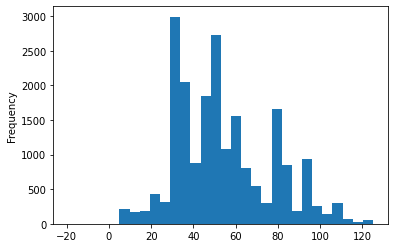

In [ ]:
# Distribution de l'écoscore
raw_data['ecoscore_score_fr'].plot.hist(bins=30)

In [ ]:
# Coup d'oil sur des valeurs abérrantes
raw_data[raw_data['ecoscore_score_fr'] < 0].head()

,code,created_t,product_name,quantity,packaging,brands,categories_en,origins_en,manufacturing_places,labels_en,emb_codes,first_packaging_code_geo,cities_tags,purchase_places,stores,countries_en,ingredients_text,allergens,traces_en,serving_size,serving_quantity,additives_n,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states_en,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category_en,energy-kj_100g,energy-kcal_100g,energy_100g,fat_100g,...,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,cocoa_100g,nutrition-score-fr_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g
942424,3478820921145,1519045104,Fourrés Chocolat-Jardin Bio,500 g,NaN,Carrefour Bio,"Beverages,Snacks,Sweet snacks,Biscuits and cak...",NaN,NaN,"Organic,Fair trade,Max Havelaar",NaN,NaN,NaN,NaN,Carrefour,France,"Farine de blé 34%, farine de blé complet 17%, ...",NaN,NaN,NaN,NaN,1.0,E500 - Sodium carbonates,0.0,NaN,0.0,NaN,e,4,Beverages,Sweetened beverages,"To be completed,Nutrition facts completed,Ingr...",NaN,-19.0,e,Filled biscuits,NaN,100.0,418.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,29.0,NaN,NaN,NaN,NaN
781988,3250390000679,1484493495,"Marmelade Orange, Avec écorces Coupées En Lame...",1 kg,"Bocal,Verre,Couvercle,Métal","Paquito,Intermarché","Plant-based foods and beverages,Beverages,Plan...",NaN,NaN,"Distributor labels,fr:Sélection Intermarché",NaN,NaN,NaN,NaN,Intermarché,France,"Sirop de glucose-fructose, oranges, sucre, gél...",NaN,NaN,NaN,NaN,1.0,E330 - Citric acid,0.0,NaN,0.0,NaN,e,4,Beverages,Sweetened beverages,"To be checked,Complete,Nutrition facts complet...",NaN,-10.0,e,Sweetened beverages,NaN,241.0,1008.0,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,18.0,NaN,NaN,NaN,NaN
823380,3263859720513,1464428981,Jus d'Orange & Fraise,75 cl,"Bouteille,Plastique",Marché Franprix,"Plant-based foods and beverages,Beverages,Plan...",NaN,NaN,NaN,NaN,NaN,NaN,"Orléans, Paris",Franprix,France,"Jus d'orange 80%, purée de fraise 20%",NaN,NaN,250 ml,250.0,0.0,NaN,0.0,NaN,0.0,NaN,c,1,Beverages,Fruit juices,"To be checked,Complete,Nutrition facts complet...",NaN,-1.0,e,Strawberries,NaN,42.0,176.0,0.1,...,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,2.0,NaN,NaN,NaN,NaN
849079,3279840000465,1509618125,Brioche pur beurre,500 g,"sachet,plastique",Brioches Fonteneau,"Beverages,Snacks,Sweet snacks,Viennoiseries,Br...",NaN,NaN,"Green Dot,Pure butter",NaN,NaN,NaN,France,Magasins U,France,"Farine de blé, levain (farine de blé, eau), be...","en:eggs,en:gluten,en:milk",NaN,NaN,NaN,2.0,"E471 - Mono- and diglycerides of fatty acids,E...",0.0,NaN,2.0,e471-mono-et-diglycerides-d-acides-gras-alimen...,e,4,Beverages,Sweetened beverages,"To be completed,Nutrition facts completed,Ingr...",NaN,-5.0,e,fr:Brioches tranchées pur beurre,1510.0,359.0,1510.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,30.0,NaN,NaN,NaN,NaN
1324702,5038862130707,1529828744,Hazelnut Unsweetened,750 ml,01 PET,Innocent,"Plant-based foods and be

In [ ]:
# Coup d'oeil sur des valeurs abérrantes
print(raw_data.product_name[raw_data['ecoscore_score_fr'] > 100])

526762          M�lisse Botte Nue 30g
526766           Hysope Botte Nue 30g
526866            Absinthe Sachet 30g
526841     Absinthe Sachet Zipp� 100g
526816     Absinthe Sachet Zipp� 500g
                      ...            
817674       boisson soja vanille bio
839962                  Soja chocolat
812040       Boisson au soja Français
1003894           Boisson au soja bio
1005358      Boisson Soja calcium bio
Name: product_name, Length: 599, dtype: object


Les valeurs >100 sont des thés ou des boissons.

L'écoscore n'est pas adapté à certaines boissons:
" les eaux et les sodas ne sont pas concernés par l'Eco-score. La méthodologie n'est pas adaptée pour ces catégories de produits et risquerait d'entrainer des contresens."  
cf. https://etiquettable.eco2initiative.com/accueil/ecoscore/


Cela est lié au fait que la methode de calcul du score prend en compte différents éléments liés à l'eau. 

Les valeurs aberrantes peuvent donc avoir plusieurs origines: une erreur lros de la saisie du score, une mauvaise normalisation en 0 et 100, une erreur dans le choix de la methode de calcul. **Il n'est pas possible de déduire la cause de ces valeurs abérrantes et de les corriger**

Même si le score appliqué aux boissons ne nous permet pas de positionner écologiquement ces mêmes boissons par rapport à d'autres produits, il peut nous permettre de comparer les boissons entre-elles. 

#### Colonnes devant avoir des valeurs entre 0 et 100

In [ ]:
raw_data.describe()

,created_t,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,ecoscore_score_fr,energy-kj_100g,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,omega-9-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,cocoa_100g,nutrition-score-fr_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g
count,3.260500e+04,8224.000000,24657.000000,24657.000000,24657.000000,20564.000000,5693.000000,23315.000000,25061.000000,24468.000000,24813.000000,143.000000,141.000000,8.000000,5.000000,1.000000,337.000000,365.000000,24735.000000,24896.000000,1.0,7.000000e+00,10029.000000,24593.000000,2.000000,2.000000,24572.000000,24572.000000,4946.000000,471.000000,7.000000,2.720000e+02,2.660000e+02,15.000000,1604.000000,233.000000,259.000000,315.000000,421.000000,1.860000e+02,30.000000,3.400000e+02,1.050000e+02,231.000000,77.000000,224.000000,679.000000,293.000000,1294.000000,95.000000,343.000000,552.000000,74.000000,29.000000,49.000000,110.000000,37.000000,5.000000,3.000000,3.500000e+01,83.000000,24.000000,114.000000,1311.000000,24233.000000,16.000000,20983.000000,3.000000,9.000000,1.0,2.000000
mean,1.504138e+09,255.545719,1.073042,0.002433,0.023239,54.102996,271.823023,64.965953,273.441581,0.898320,0.450838,1.283979,0.816610,0.348914,2.515840,0.000012,0.002078,0.002185,13.497612,11.899771,1.0,5.285857e+00,0.556288,0.895117,0.700750,0.200460,0.218596,0.087456,10.442420,0.002722,0.158388,2.014964e-02,3.357800e-02,0.009618,0.248205,0.253491,0.024774,0.218122,0.045618,5.995148e-01,0.010445,4.351492e-03,2.517594e-01,0.150900,0.038620,0.541941,0.157190,0.046830,1.413003,0.169131,0.352725,0.631514,0.003576,0.004325,0.321451,0.001641,1.408784,0.000048,6.266674,1.379134e-03,0.108961,0.895795,6.861780,49.364754,16.721904,2.737500,6.777677,0.356333,0.001935,0.4,0.015000
std,5.836624e+07,1569.731787,1.782384,0.049270,0.160315,22.729433,361.554398,94.437942,393.075718,4.030873,2.521139,2.863073,1.049836,0.352253,4.920879,NaN,0.029305,0.013746,20.172835,18.857420,NaN,8.300783e+00,2.784477,4.464256,0.988889,0.282192,2.584190,1.033677,10.966019,0.030343,0.415213,2.307254e-01,3.065155e-01,0.036873,2.631700,2.638811,0.300627,3.388436,0.328704,4.018276e+00,0.056787,4.532602e-02,1.341642e+00,2.113901,0.176646,2.832717,0.452532,0.245818,22.948073,0.265520,6.479257,5.853819,0.008062,0.012731,1.999769,0.013325,7.373408,0.000075,10.854179,5.556915e-03,0.359273,2.104642,1.328883,33.539085,32.802773,5.948655,6.391524,0.558498,0.005703,NaN,0.007071
min,1.328993e+09,0.000000,0.000000,0.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,-1.000000,-1.000000,1.0,0.000000e+00,0.000000,0.000000,0.001500,0.000920,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,4.100000e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.330000e-07,0.000003,0.000000e+00,8.000000e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000,0.000002,0.000003,2.250000e-08,0.000000,0.000350,0.006400,0.000000,0.000000,0.600000,-11.000000,0.000000,0.000005,0.4,0.010000
25%,1.476550e+09,100.000000,0

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


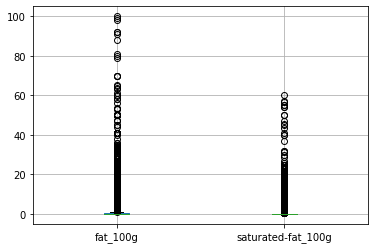

In [ ]:
# boxplot
raw_data.boxplot(['fat_100g', 'saturated-fat_100g'])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


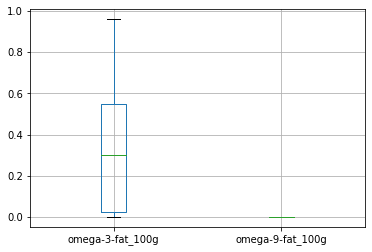

In [ ]:
# boxplot
raw_data.boxplot(['omega-3-fat_100g', 'omega-9-fat_100g'])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


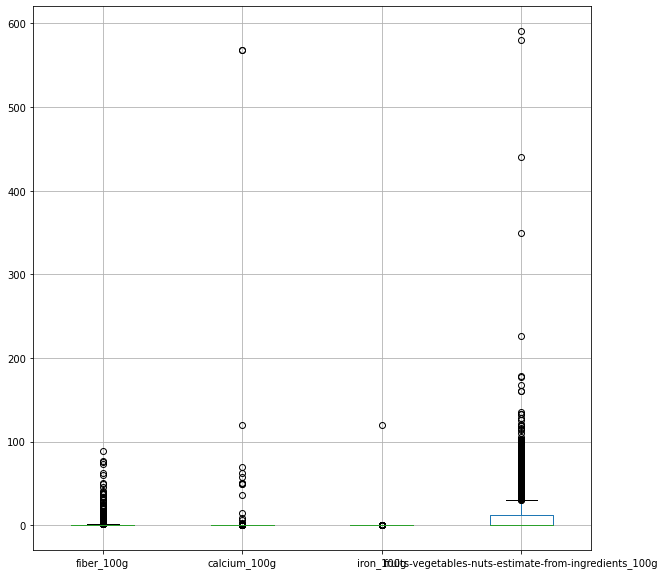

In [ ]:
# boxplot
raw_data.boxplot(['fiber_100g', 'calcium_100g', 'iron_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g'])

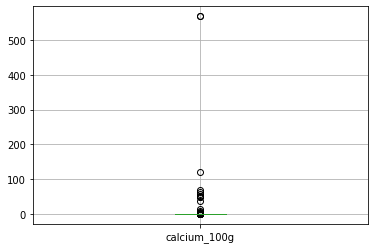

In [ ]:
# boxplot
raw_data.boxplot(['calcium_100g'])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


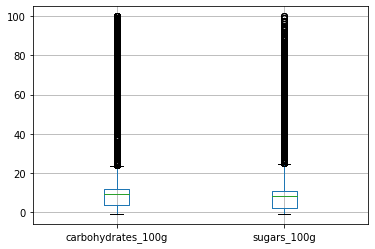

In [ ]:
# boxplot
raw_data.boxplot(['carbohydrates_100g', 'sugars_100g'])

In [ ]:
# Supprime les lignes ayant des valeurs aberrantes (>100 ou <0)
raw_data = raw_data[~(raw_data[['fat_100g', 'saturated-fat_100g', 'omega-3-fat_100g', 'omega-9-fat_100g', 'fiber_100g', 'calcium_100g', 'iron_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g','carbohydrates_100g', 'sugars_100g']] > 100).any(axis=1)]
raw_data = raw_data[~(raw_data[['fat_100g', 'saturated-fat_100g', 'omega-3-fat_100g', 'omega-9-fat_100g', 'fiber_100g', 'calcium_100g', 'iron_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g','carbohydrates_100g', 'sugars_100g']] < 0).any(axis=1)]

In [ ]:
# Statistiques sur les nombre de lignes et colonnes à cette étapes du nettoyage
clean_step('suppression des valeurs aberrantes')

,étape,n colonnes,n lignes,% lignes del,% lignes restantes
0,import,187,1998448,0.000000,1.000000
1,filtre sur la France,187,847601,57.587038,42.412962
2,sélection des boissons,187,40114,95.267349,2.007258
3,suppression des colonnes vides,139,40114,0.000000,2.007258
4,suppression des lignes sans nutrition facts,139,34330,14.418906,1.717833
5,suppression des lignes sans nom de produit,139,34160,0.495194,1.709326
6,suppression des doublons,139,32605,4.552108,1.631516
7,suppression des colonnes inutiles ou redondantes,101,32605,0.000000,1.631516
8,suppression des valeurs aberrantes,101,32566,0.119614,1.629565


## Revue des variables categorielles restantes pour conservation ou drop

On drop ou garde certtaines variables categorielles en fonction de leur exploitabilité ou du nombre de valeurs complètées

#### categories_en,  main_category_en et pnns_groups_2

In [ ]:
# imprime le nombre de catégories uniques
print('nombre de categories_en uniques:', raw_data['categories_en'].str.get_dummies(',').shape[1])
print('nombre de main_category_en uniques:', raw_data['main_category_en'].str.get_dummies(',').shape[1])
print('nombre de pnns_groups_2 uniques:', len(raw_data['pnns_groups_2'].unique()))

nombre de categories_en uniques: 2399
nombre de main_category_en uniques: 1911
nombre de pnns_groups_2 uniques: 9


In [ ]:
# tags les plus récurrents
pd.set_option("display.max_rows", 101)
raw_data['categories_en'].str.get_dummies(',').sum().sort_values(ascending=False).head()

Beverages                          32520
Plant-based foods and beverages    13714
Plant-based beverages              13037
Fruit-based beverages               8473
Juices and nectars                  7201
dtype: int64

In [ ]:
# Nombre de catégories uniques
print('nombre de main_category_en', raw_data['main_category_en'].str.get_dummies(',').shape[1])

nombre de main_category_en 1911


In [ ]:
# Drop
raw_data = raw_data.drop(['categories_en'], axis = 1)

In [ ]:
# Nombre de groupes pnns de second rang uniques
raw_data['pnns_groups_2'].unique()

array(['Alcoholic beverages', 'Fruit nectars',
       'Waters and flavored waters', 'Sweetened beverages',
       'Fruit juices', 'Unsweetened beverages',
       'Plant-based milk substitutes', 'Artificially sweetened beverages',
       'Teas and herbal teas and coffees'], dtype=object)

pnns_groups_2 n'a pas de valeurs manquantes. Les 2 autres colonnes sont incomplètes et plus difficilement exploitable. Elles comportent beaucoup de tags ne présentant que quelques observations. Il y'a également beaucoup de redondance entre les colonnes et les tags.

Elles offrent cependant une catégorisation beaucoup plus granulaire, qui sera utile pour recommander des produits similaires. La redondance entre les colonnes est beaucoup moins problématique pour cet usage.

#### allergens et additives_en

In [ ]:
print('nombre d allergens différents:', raw_data['allergens'].str.get_dummies(',').shape[1])
print('nombre d additifs différents:', raw_data['additives_en'].str.get_dummies(',').shape[1])

nombre d allergens différents: 148
nombre d additifs différents: 262


On garde les allergens et les additifs pour l'instant.

#### labels

In [ ]:
print('nombre de labels', raw_data['labels_en'].str.get_dummies(',').shape[1])


nombre de labels 2015


Bien que ce champ soit difficilement exploitable et peu formaté, on va pouvoir en tirer plusieurs types de labels: le bio/organic, le fairtrade/commerce équitable ainsi que le Made In France.

On va chercher des patterns correspondant à ces labels:    
- bio/organic
- fairtrade/fair trade/equitable
- made in france/fabriqué en france


In [ ]:
# créé 3 colonnes Dummies
raw_data['organic'] = raw_data["labels_en"].str.contains("bio|organic", na = False, case=False).astype(int)
raw_data['fairtrade'] = raw_data["labels_en"].str.contains("fairtrade|fair trade|equitable|équitable", na = False, case=False).astype(int)
raw_data['madeinfrance'] = raw_data["labels_en"].str.contains("made in france|madeinefrance|fabriqué en france|fabrique en france|fabriquéenfrance|fabriqueenfrance", na = False, case=False).astype(int)

# print le nombre d'observations pour chaque label
print('nombre de produits bio:', raw_data['organic'].sum())
print('nombre de produits issus du commerce équitable:', raw_data['fairtrade'].sum())
print('nombre de produits Made in France:', raw_data['madeinfrance'].sum())

# drop labels_en
raw_data = raw_data.drop(['labels_en'], axis = 1)

nombre de produits bio: 6123
nombre de produits issus du commerce équitable: 527
nombre de produits Made in France: 1351


#### Drop d'autres colonnes inutiles ou inexploitables

On se sépare des données geographiques (magasin, ville, origine des ingrédients, etc.)

On se sépare du champ des ingrédients_text car inexploitable facilement (idem categories_en et labels)

On retire les quantités de produits

In [ ]:
# Drop de colonnes
raw_data = raw_data.drop(['packaging', 'origins_en', 'manufacturing_places', 'emb_codes', 'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores', 'countries_en', 'ingredients_text', 'serving_size', 'serving_quantity', 'states_en'], axis = 1)

In [ ]:
# Check
raw_data.info(verbose=True, null_counts=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 32566 entries, 1087157 to 752556
Data columns (total 89 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   code                                                   32566 non-null  object 
 1   created_t                                              32566 non-null  int64  
 2   product_name                                           32566 non-null  object 
 3   quantity                                               21458 non-null  object 
 4   brands                                                 29454 non-null  object 
 5   allergens                                              3793 non-null   object 
 6   traces_en                                              1412 non-null   object 
 7   additives_n                                            24619 non-null  float64
 8   additives_en                           

In [ ]:
# Statistiques sur les nombre de lignes et colonnes à cette étapes du nettoyage
clean_step('suppression de colonnes inexploitables ou inutiles')

,étape,n colonnes,n lignes,% lignes del,% lignes restantes
0,import,187,1998448,0.000000,1.000000
1,filtre sur la France,187,847601,57.587038,42.412962
2,sélection des boissons,187,40114,95.267349,2.007258
3,suppression des colonnes vides,139,40114,0.000000,2.007258
4,suppression des lignes sans nutrition facts,139,34330,14.418906,1.717833
5,suppression des lignes sans nom de produit,139,34160,0.495194,1.709326
6,suppression des doublons,139,32605,4.552108,1.631516
7,suppression des colonnes inutiles ou redondantes,101,32605,0.000000,1.631516
8,suppression des valeurs aberrantes,101,32566,0.119614,1.629565
9,suppression de colonnes inexploitables ou inut...,89,32566,0.000000,1.629565


## Imputations

### Colonnes relatives à l'énergie

energy-kj_100g et energy_100g ont les mêmes valeurs quand les 2 colones sont complètées pour un produit. Ces 2 colonnes sont dans la même unité (kj)

energy-kcal_100g est dans une unité différente (kcal). On peut cependant faire la conversion d'une unité à l'autre.

Sachant que:
1 kilocalorie (kcal) = 4,1868 kilojoule (kJ) 

On peut faire une colonne energy_kcal_100g en complétant les valeurs manquantes de chaque colonne.



In [ ]:
# Convertit en kcal 
raw_data['energy-kj_100g'] = raw_data['energy-kj_100g'].apply(lambda x: x/4,1868)
raw_data['energy_100g'] = raw_data['energy_100g'].apply(lambda x: x/4,1868)

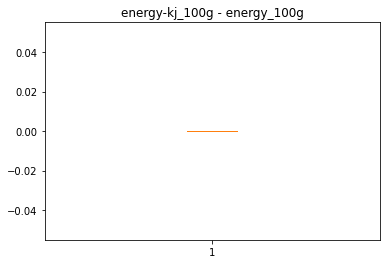

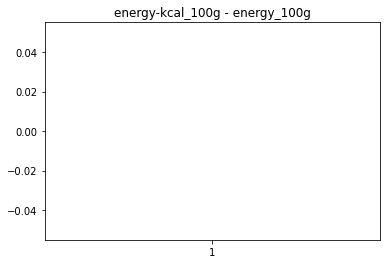

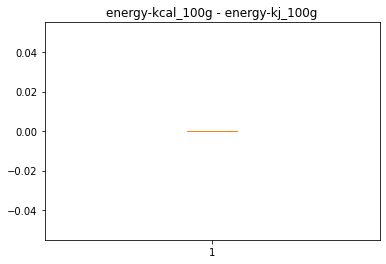

In [ ]:
# Boxplots des différences entre les varibales energies en kcal
plt.boxplot(np.where((raw_data['energy-kj_100g'].isna() == False) & (raw_data['energy_100g'].isna() == False) & (raw_data['energy-kj_100g'] != raw_data['energy_100g']), np.absolute((raw_data['energy-kj_100g'])-(raw_data['energy_100g'])), 0))
plt.title('energy-kj_100g - energy_100g')
plt.show()

plt.boxplot(np.where((raw_data['energy-kcal_100g'].isna() == False) & (raw_data['energy_100g'].isna() == False) & (raw_data['energy-kcal_100g'] != raw_data['energy_100g']), np.absolute((raw_data['energy-kcal_100g'])-(raw_data['energy-kj_100g'])), 0))
plt.title('energy-kcal_100g - energy_100g')
plt.show()

plt.boxplot(np.where((raw_data['energy-kcal_100g'].isna() == False) & (raw_data['energy-kj_100g'].isna() == False) & (raw_data['energy-kcal_100g'] != raw_data['energy-kj_100g']), np.absolute((raw_data['energy_100g'])-(raw_data['energy-kj_100g'])), 0))
plt.title('energy-kcal_100g - energy-kj_100g')
plt.show()

- energy-kj_100g et energy_100g ont les mêmes valeurs quand les deux colonnes ne sont pas NaN
- Quand energy-kj_100g ou energy_100g ainsi que energy-kcal_100g ne sont pas NaN, les valeurs sont rarement différentes

On regarde les quelques instances ou cette différence est supérieure à 50 kcal pour 100g

In [ ]:
raw_data[np.where((raw_data['energy-kcal_100g'].isna() == False) & (raw_data['energy-kj_100g'].isna() == False) & (raw_data['energy-kcal_100g'] != raw_data['energy-kj_100g']), np.absolute((raw_data['energy-kcal_100g'])-(raw_data['energy-kj_100g'])), 0) > 50]


,code,created_t,product_name,quantity,brands,allergens,traces_en,additives_n,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category_en,energy-kj_100g,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,omega-9-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,...,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,cocoa_100g,nutrition-score-fr_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,organic,fairtrade,madeinfrance
1414582,5449000054531,1559731938,Fanta,330 ml,"Fanta, The Coca-Cola Company, Coca-Cola",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e,NaN,Beverages,Sweetened beverages,NaN,NaN,NaN,Sodas,28.750,89.000000,28.750,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.000000,21.000000,NaN,NaN,NaN,27.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,0,0,0
829236,3266810641636,1585427445,Coca cola zero sucre,NaN,Coca-Cola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e,NaN,Beverages,Sweetened beverages,NaN,NaN,NaN,Sweetened beverages,45.000,180.000000,45.000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.600000,10.600000,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,0,0,0
878527,3336770001365,1518872685,sirop mangue goyave,NaN,Bigallet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beverages,Sweetened beverages,NaN,80.0,b,Flavoured syrups,372.500,39.000000,372.500,0.300700,0.002100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.400000,9.300000,NaN,NaN,0.00,0.010500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1134783,3800022403189,1555694742,Strongbow Apple Ciders - Fructe de pădure,330 ml,"Strongbow,Heineken",NaN,NaN,2.0,"E224 - Potassium metabisulphite,E296 - Malic acid",0.0,NaN,0.0,NaN,NaN,4,Alcoholic beverages,Alcoholic beverages,NaN,33.0,d,Ciders,12.250,206.000000,12.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
982334,3564700087657,1457088894,Cafe soluble Plantation Selection,200 g,"Plantation,Marque Repère",NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,c,NaN,Beverages,Unsweetened beverages,NaN,NaN,NaN,Non-Alcoholic beverages,298.250,1.000000,298.250,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,28.00,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,5.0,NaN,NaN,NaN,NaN,0,0,0
910216,3397510211154,1506750463,Pur jus clementine,NaN,Pressoirs de Provence,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,c,1,Beverages,Fruit juices,NaN,44.0,c,Clementine juices,51.500,206.000000,51.500,0.500000,0.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,10.000000,NaN,NaN,0.07,0.800000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,NaN,4

Les observations où les colonnes relatives aux valeurs energétiques sont contradictoires ne présentent pas d'autres particularités.

On va fill une partie des valeurs manquantes d'energy-kcal_100g avec les deux autres colonnes, car quand toutes les valeurs sont présentes, il y'a peu d'incohérences, et une partie de ces incohérences sont peu importantes en terme de kcal.

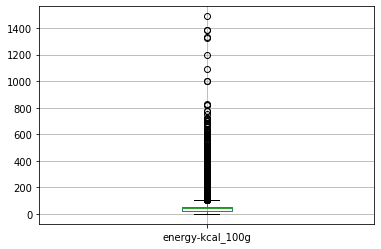

In [ ]:
# Fill
raw_data['energy-kcal_100g'] = raw_data['energy-kcal_100g'].fillna(raw_data['energy-kj_100g'])
raw_data['energy-kcal_100g'] = raw_data['energy-kcal_100g'].fillna(raw_data['energy_100g'])

# Drop
raw_data = raw_data.drop(['energy-kj_100g', 'energy_100g'], axis = 1)

raw_data.boxplot(['energy-kcal_100g'])

In [ ]:
# Données manquantes
print('NaNs :', raw_data['energy-kcal_100g'].isna().sum())
print('NaNs en commun avec les variables utilisées pour calculer l energie pour 100g: ', np.where((raw_data['energy-kcal_100g'].isna() == True) & (raw_data['proteins_100g'].isna() == True) & (raw_data['carbohydrates_100g'].isna() == True) & (raw_data['alcohol_100g'].isna() == True),1,0).sum())

NaNs : 7541
NaNs en commun avec les variables utilisées pour calculer l energie pour 100g:  3812


~7600 Nans sur ~33000 lignes représente un part importante du dataset. Nous allons fill avec la médiane du groupe pnn.

In [ ]:
# calcul la valeur energetique pour 100g pour tous les produits
raw_data['energie'] = raw_data['energy-kcal_100g'].fillna(raw_data.groupby('pnns_groups_2')['energy-kcal_100g'].transform('median'))

L'erreur moyenne est d'environ 7 kcal, j'estime que la methode est assez performante pour l'utiliser et fill les données manquantes.

In [ ]:
# Fill
raw_data['energy-kcal_100g'] = np.where(raw_data['energy-kcal_100g'].isna() == True, raw_data['energie'], raw_data['energy-kcal_100g'])

# Drop colonne energie
raw_data = raw_data.drop(['energie'], axis = 1)

In [ ]:
# Rapide coup d'oeil sur les produits très caloriques
raw_data[raw_data['energy-kcal_100g'] > 1000]

,code,created_t,product_name,quantity,brands,allergens,traces_en,additives_n,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category_en,energy-kcal_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,omega-9-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,salt_100g,...,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,cocoa_100g,nutrition-score-fr_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,organic,fairtrade,madeinfrance
637454,2393436356956,1596393837,Sirop de violette des Alpes Maritimes pur sucr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beverages,Sweetened beverages,NaN,80.0,b,Violet Syrups,1326.0,0.5,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,77.0,NaN,NaN,NaN,0.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
858002,3292483840045,1569435743,Sirop menthe rieme,NaN,Rieme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beverages,Sweetened beverages,NaN,80.0,b,Mint syrups,1386.0,0.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.3,78.0,NaN,NaN,NaN,0.3,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
970897,3560070381791,1525778115,Blle 1L Sirop Pamplemousse Rose Saxo,NaN,Saxo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beverages,Sweetened beverages,NaN,80.0,b,fr:Sirops de pamplemousse,1384.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,80.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
756221,3180290073346,1528634668,Sirop de grenadine,NaN,Giffard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beverages,Sweetened beverages,NaN,80.0,b,Grenadine,1095.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,77.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1121954,3770005113001,1593271925,Toucan,70cl,Toucan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alcoholic beverages,Alcoholic beverages,NaN,50.0,c,fr:Rhum des départements français d'outre-mer,1200.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,99.0,NaN,NaN,0.0,0.0,NaN,NaN,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
950046,3501271151042,1517788856,220G Tbrulees Jelly Fruits Verquin,NaN,Verquin,NaN,NaN,6.0,"E100 - Curcumin,E120 - Cochineal,E296 - Malic ...",0.0,NaN,0.0,NaN,e,4,Beverages,Sweetened beverages,NaN,NaN,NaN,Sweetened beverages,1330.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,52.0,NaN,NaN,NaN,5.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,22.0,NaN,NaN,NaN,NaN,1,0,0
889933,3352396200388,1508441887,Badiane ou anis etoile,NaN,Festifruits,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,1,Beverages,Unsweetened beverages,NaN,90.0,b,Star anise,1489.0,16.0,0.9,NaN,NaN,NaN

Il s'agit de sirops (ou d'huiles). Cela semble normal pour les sirops (pour les huiles aussi, même s'il s'agit de produit taggués dans la mauvaise catégorie).

In [ ]:
# Rapide coup d'oeil sur une petite partie des nombreux produis n'ayant pas de calories
raw_data[raw_data['energy-kcal_100g'] == 0].head()

,code,created_t,product_name,quantity,brands,allergens,traces_en,additives_n,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category_en,energy-kcal_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,omega-9-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,salt_100g,...,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,cocoa_100g,nutrition-score-fr_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,organic,fairtrade,madeinfrance
237104,75496667006,1518382643,Angostura 1919 Rhum 40%,70cl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alcoholic beverages,Alcoholic beverages,NaN,NaN,NaN,Alcoholic beverages,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
786774,3250391654796,1582796353,"Vieille Cave, Vin rouge de table francais, la ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alcoholic beverages,Alcoholic beverages,NaN,23.0,d,Red wines,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1053687,3760007400018,1586541055,Didier Barbe Aperitif a base de vin rouge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alcoholic beverages,Alcoholic beverages,NaN,23.0,d,Red wines,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
991889,3570590109713,1590869070,Whisky du jura,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alcoholic beverages,Alcoholic beverages,NaN,37.0,d,Whisky,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1063465,3760045535208,1580833027,Bière ambree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alcoholic beverages,Alcoholic beverages,NaN,37.0,d,Amber beers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


Il s'agit d'eau et de boissons "Diet", Cela semble normal.

### nutrition-score-fr_100g et nutriscore_grade

In [ ]:
# Valeurs manquantes
print('nombre de Nans nutriscore_grade :', raw_data['nutriscore_grade'].isna().sum())
print('nombre de Nans nutrition-score-fr_100g :', raw_data['nutrition-score-fr_100g'].isna().sum())
print('nombre de Nans communs :', np.where((raw_data['nutriscore_grade'].isna()) & (raw_data['nutrition-score-fr_100g'].isna()), 1, 0).sum())

nombre de Nans nutriscore_grade : 11618
nombre de Nans nutrition-score-fr_100g : 11618
nombre de Nans communs : 11618


On ne peut pas fill une colonne avec l'autre, car les NaNs sont tous communs aux deux colonnes.


Par ailleurs, on sait que:
- Le nutriscore des boissons n'est pas calculé de la même manière que pour les autres produits.
- il n'existe pas de méthode pour calculer le nutriscore des boissons alcoolisées (>1.2% d'alcool).

In [ ]:
print('nombre de produits contenant plus de 1.2% d alcool :', np.where((raw_data['alcohol_100g'] > 1.2), 1, 0).sum())
print('nombre de Nans pour les produits contenant plus de 1.2% d alcool :', np.where((raw_data['alcohol_100g'] > 1.2) & raw_data['nutriscore_grade'].isna() == True, 1, 0).sum())

nombre de produits contenant plus de 1.2% d alcool : 4251
nombre de Nans pour les produits contenant plus de 1.2% d alcool : 4244


Plus d'un tier des données manquantes du nutriscore est constitué des boissons alcoolisées.

Les points positifs et négatifs du nutriscore pour les boissons sont attribués selon le tableau suivant:
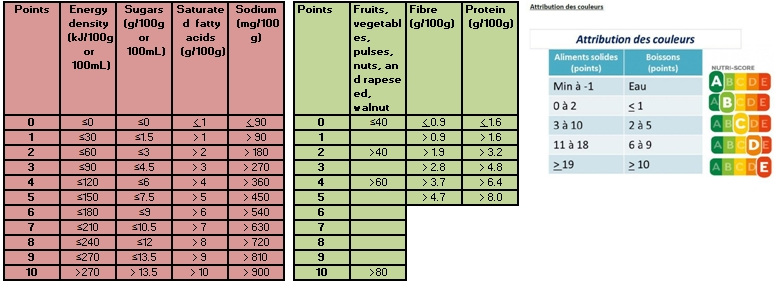

In [ ]:
# vérification des variables utilisées pour calculer le nutriscore
raw_data[['energy-kcal_100g', 'sugars_100g', 'saturated-fat_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'fiber_100g', 'proteins_100g']].info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32566 entries, 1087157 to 752556
Data columns (total 8 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   energy-kcal_100g                                       32566 non-null  float64
 1   sugars_100g                                            24859 non-null  float64
 2   saturated-fat_100g                                     24778 non-null  float64
 3   sodium_100g                                            24534 non-null  float64
 4   fruits-vegetables-nuts_100g                            1304 non-null   float64
 5   fruits-vegetables-nuts-estimate-from-ingredients_100g  24195 non-null  float64
 6   fiber_100g                                             10009 non-null  float64
 7   proteins_100g                                          24557 non-null  float64
dtypes: float64(8)
memory usage: 2.2 MB


**On a d'abord besoin d'imputer les valeurs manquantes de ces colonnes pour calculer le nutriscore puis le nutrigrade.**

### fruits-vegetables-nuts_100g et fruits-vegetables-nuts-estimate-from-ingredients_100g

In [ ]:
# Fill
raw_data['fruits-vegetables-nuts_100g'] = raw_data['fruits-vegetables-nuts_100g'].fillna(raw_data['fruits-vegetables-nuts-estimate-from-ingredients_100g'])

# Drop
raw_data = raw_data.drop(['fruits-vegetables-nuts-estimate-from-ingredients_100g'], axis = 1)

### Colonnes _100g

On impute par des 0. Il est légitime de penser que les données manquantes sont equivalentes à l'abscence de cet élément dans le produit dans la grande majorité des cas.

In [ ]:
# Fill NaN par 0 pour les variables X_100g
nutrition_facts = list(raw_data.columns[(raw_data.columns.str.endswith('_100g') == True) & (raw_data.columns != 'nutrition-score-fr_100g') & (raw_data.columns != 'energy-kcal_100g')])
nutrition_facts

# Fill par nom de colonne
raw_data[nutrition_facts] = raw_data[nutrition_facts].fillna(0)


# Check
raw_data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32566 entries, 1087157 to 752556
Data columns (total 86 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   code                                        32566 non-null  object 
 1   created_t                                   32566 non-null  int64  
 2   product_name                                32566 non-null  object 
 3   quantity                                    21458 non-null  object 
 4   brands                                      29454 non-null  object 
 5   allergens                                   3793 non-null   object 
 6   traces_en                                   1412 non-null   object 
 7   additives_n                                 24619 non-null  float64
 8   additives_en                                9843 non-null   object 
 9   ingredients_from_palm_oil_n                 24619 non-null  float64
 10  ing

### Imputation du nutrition-score-fr_100g et nutriscore_grade
Le nutriscore est calculé selon le tableau suivant, constitué de la methode décrite dans ce document: https://www.santepubliquefrance.fr/content/download/150263/file/2021_07_21_QR_scientifique_et_technique_V41_EN.pdf

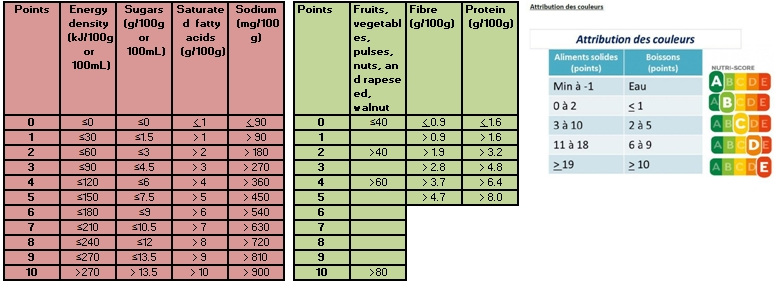

In [ ]:
# vérification des variables utilisées pour calculer le nutriscore
raw_data[['energy-kcal_100g', 'sugars_100g', 'saturated-fat_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g', 'fiber_100g', 'proteins_100g']].info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32566 entries, 1087157 to 752556
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   energy-kcal_100g             32566 non-null  float64
 1   sugars_100g                  32566 non-null  float64
 2   saturated-fat_100g           32566 non-null  float64
 3   sodium_100g                  32566 non-null  float64
 4   fruits-vegetables-nuts_100g  32566 non-null  float64
 5   fiber_100g                   32566 non-null  float64
 6   proteins_100g                32566 non-null  float64
dtypes: float64(7)
memory usage: 2.0 MB


On sait que seul l'eau peut obtenir le grade A. Regardons le groupe pnn correspondant:

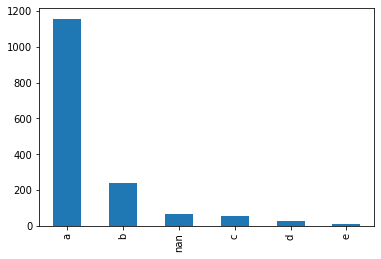

In [ ]:
# répartition des grades pour les eaux
raw_data[raw_data['pnns_groups_2'] == 'Waters and flavored waters']['nutriscore_grade'].value_counts(dropna=False).plot(kind='bar')


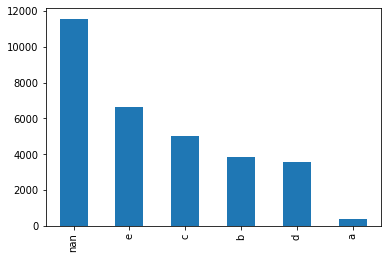

In [ ]:
# répartition des grades pour les autres produits (non eaux)
raw_data[raw_data['pnns_groups_2'] != 'Waters and flavored waters']['nutriscore_grade'].value_counts(dropna=False).plot(kind='bar')

On constate en effet que les eaux ont majoritairement le grade A, et que très peu d'autres boissons ont ce grade.

In [ ]:
# calcul du nutriscore pour chaque ligne a partir des données nutritionnelles
def calc_score(row):
    # energie
    if row['energy-kcal_100g']*4.1868 <= 0:
        energie = 0
    elif ((row['energy-kcal_100g']*4.1868 > 0) and (row['energy-kcal_100g']*4.1868 <= 30)):
        energie = 1
    elif ((row['energy-kcal_100g']*4.1868 > 30) and (row['energy-kcal_100g']*4.1868 <= 60)):
        energie = 2
    elif ((row['energy-kcal_100g']*4.1868 > 60) and (row['energy-kcal_100g']*4.1868 <= 90)):
        energie = 3
    elif ((row['energy-kcal_100g']*4.1868 > 90) and (row['energy-kcal_100g']*4.1868 <= 120)):
        energie = 4
    elif ((row['energy-kcal_100g']*4.1868 > 120) and (row['energy-kcal_100g']*4.1868 <= 150)):
        energie = 5
    elif ((row['energy-kcal_100g']*4.1868 > 150) and (row['energy-kcal_100g']*4.1868 <= 180)):
        energie = 6
    elif ((row['energy-kcal_100g']*4.1868 > 180) and (row['energy-kcal_100g']*4.1868 <= 210)):
        energie = 7
    elif ((row['energy-kcal_100g']*4.1868 > 210) and (row['energy-kcal_100g']*4.1868 <= 240)):
        energie = 8
    elif ((row['energy-kcal_100g']*4.1868 > 240) and (row['energy-kcal_100g']*4.1868 <= 270)):
        energie = 9
    else:
        energie = 10    
    # sucre
    if row['sugars_100g'] <= 0:
        sucre = 0
    elif ((row['sugars_100g'] > 0) and (row['sugars_100g'] <= 1.5)):
        sucre = 1
    elif ((row['sugars_100g'] > 1.5) and (row['sugars_100g'] <= 3)):
        sucre = 2
    elif ((row['sugars_100g'] > 3) and (row['sugars_100g'] <= 4.5)):
        sucre = 3
    elif ((row['sugars_100g'] > 4.5) and (row['sugars_100g'] <= 6)):
        sucre = 4
    elif ((row['sugars_100g'] > 6) and (row['sugars_100g'] <= 7.5)):
        sucre = 5
    elif ((row['sugars_100g'] > 7.5) and (row['sugars_100g'] <= 9)):
        sucre = 6
    elif ((row['sugars_100g'] > 9) and (row['sugars_100g'] <= 10.5)):
        sucre = 7
    elif ((row['sugars_100g'] > 10.5) and (row['sugars_100g'] <= 12)):
        sucre = 8
    elif ((row['sugars_100g'] > 12) and (row['sugars_100g'] <= 13.5)):
        sucre = 9
    else:
        sucre = 10 
    # gsat (graisses saturées)
    if row['saturated-fat_100g'] <= 1:
        gsat = 0
    elif ((row['saturated-fat_100g'] > 1) and (row['saturated-fat_100g'] <= 2)):
        gsat = 1
    elif ((row['saturated-fat_100g'] > 2) and (row['saturated-fat_100g'] <= 3)):
        gsat = 2
    elif ((row['saturated-fat_100g'] > 3) and (row['saturated-fat_100g'] <= 4)):
        gsat = 3
    elif ((row['saturated-fat_100g'] > 4) and (row['saturated-fat_100g'] <= 5)):
        gsat = 4
    elif ((row['saturated-fat_100g'] > 5) and (row['saturated-fat_100g'] <= 6)):
        gsat = 5
    elif ((row['saturated-fat_100g'] > 6) and (row['saturated-fat_100g'] <= 7)):
        gsat = 6
    elif ((row['saturated-fat_100g'] > 7) and (row['saturated-fat_100g'] <= 8)):
        gsat = 7
    elif ((row['saturated-fat_100g'] > 8) and (row['saturated-fat_100g'] <= 9)):
        gsat = 8
    elif ((row['saturated-fat_100g'] > 9) and (row['saturated-fat_100g'] <= 10)):
        gsat = 9
    else:
        gsat = 10 
    # sodium
    if row['sodium_100g']*1000 <= 90:
        sodium = 0
    elif ((row['sodium_100g']*1000 > 90) and (row['sodium_100g']*1000 <= 180)):
        sodium = 1
    elif ((row['sodium_100g']*1000 > 180) and (row['sodium_100g']*1000 <= 270)):
        sodium = 2
    elif ((row['sodium_100g']*1000 > 270) and (row['sodium_100g']*1000 <= 360)):
        sodium = 3
    elif ((row['sodium_100g']*1000 > 360) and (row['sodium_100g']*1000 <= 450)):
        sodium = 4
    elif ((row['sodium_100g']*1000 > 450) and (row['sodium_100g']*1000 <= 540)):
        sodium = 5
    elif ((row['sodium_100g']*1000 > 540) and (row['sodium_100g']*1000 <= 630)):
        sodium = 6
    elif ((row['sodium_100g']*1000 > 630) and (row['sodium_100g']*1000 <= 720)):
        sodium = 7
    elif ((row['sodium_100g']*1000 > 720) and (row['sodium_100g']*1000 <= 810)):
        sodium = 8
    elif ((row['sodium_100g']*1000 > 810) and (row['sodium_100g']*1000 <= 900)):
        sodium = 9
    else:
        sodium = 10
    # fruit
    if row['fruits-vegetables-nuts_100g'] <= 40:
        fruit = 0
    elif ((row['fruits-vegetables-nuts_100g'] > 40) and (row['fruits-vegetables-nuts_100g'] <= 60)):
        fruit = 2
    elif ((row['fruits-vegetables-nuts_100g'] > 60) and (row['fruits-vegetables-nuts_100g'] <= 80)):
        fruit = 4
    else:
        fruit = 10
    # fibre
    if row['fiber_100g'] <= 0.9:
        fibre = 0
    elif ((row['fiber_100g'] > 0.9) and (row['fiber_100g'] <= 1.9)):
        fibre = 1
    elif ((row['fiber_100g'] > 1.9) and (row['fiber_100g'] <= 2.8)):
        fibre = 2
    elif ((row['fiber_100g'] > 2.8) and (row['fiber_100g'] <= 3.7)):
        fibre = 3
    elif ((row['fiber_100g'] > 3.7) and (row['fiber_100g'] <= 4.7)):
        fibre = 4
    else:
        fibre = 5
    # proteines
    if row['proteins_100g'] <= 0.9:
        proteines = 0
    elif ((row['proteins_100g'] > 0.9) and (row['proteins_100g'] <= 1.9)):
        proteines = 1
    elif ((row['proteins_100g'] > 1.9) and (row['proteins_100g'] <= 2.8)):
        proteines = 2
    elif ((row['proteins_100g'] > 2.8) and (row['proteins_100g'] <= 3.7)):
        proteines = 3
    elif ((row['proteins_100g'] > 3.7) and (row['proteins_100g'] <= 4.7)):
        proteines = 4
    else:
        proteines = 5
    
    # score
    nutriscore = energie+sucre+gsat+sodium-fruit-fibre-proteines
    
    return nutriscore



# calcul du nutrigrade pour chaque ligne a partir du nutriscore calculé par la fonction précédente
def calc_grade(row):
    if ((row['nutriscore'] <= 0) and (row['pnns_groups_2'] == 'Waters and flavored waters')):
        nutrigrade = 'a'
    elif ((row['nutriscore'] <= 1) and (row['pnns_groups_2'] != 'Waters and flavored waters') or (row['nutriscore'] == 1) and (row['pnns_groups_2'] == 'Waters and flavored waters')): 
        nutrigrade = 'b'
    elif ((row['nutriscore'] >= 2) and (row['nutriscore'] <= 5)):
        nutrigrade = 'c'
    elif ((row['nutriscore'] >= 6) and (row['nutriscore'] <= 9)):
        nutrigrade = 'd'
    elif ((row['pnns_groups_2'] == 'Alcoholic beverages') or (row['alcohol_100g'] > 1.2)):
        nutrigrade = 'alcool'
    else:
        nutrigrade = 'e'
        
    return nutrigrade

In [ ]:
# Calcul des nutriscores et nutrigrades à l'aide des fonctions
raw_data['nutriscore'] = raw_data.apply(lambda row: calc_score(row),axis=1)
raw_data['nutrigrade'] = raw_data.apply(lambda row: calc_grade(row),axis=1)

In [ ]:
# accuracy sur les lignes avec le nutriscore_grade renseigné (hors alcools)
np.where((raw_data['nutrigrade'] == raw_data['nutriscore_grade']) & (raw_data['pnns_groups_2'] != 'Alcoholic beverages') & (raw_data['nutriscore_grade'].isna() == False), 1, 0).sum() / np.where((raw_data['pnns_groups_2'] != 'Alcoholic beverages')  & (raw_data['nutriscore_grade'].isna() == False), 1, 0).sum()

0.7248351018067106

Avec cette méthode, on retrouve le bon grade dans environ 72% des cas sur les données où le nutriscore_grade est renseigné dans le dataset d'origine (hors alcools).

On va donc remplacer les Nans grâce à cette méthode, bien qu'elle soit loin d'être parfaite. Le but final étant d'avoir des données pour un prototype, j'estime que ~70% d'accuracy est suffisant pour cet usage.

In [ ]:
# Fill
raw_data['nutrigrade'] = np.where(raw_data['nutriscore_grade'].isna() == True, raw_data['nutrigrade'], raw_data['nutriscore_grade'])
raw_data['nutrigrade'] = np.where((raw_data['alcohol_100g'] > 1.2) | (raw_data['nutrigrade'] == 'alcool') | (raw_data['pnns_groups_2'] == 'Alcoholic beverages'), 'alcool', raw_data['nutrigrade'])

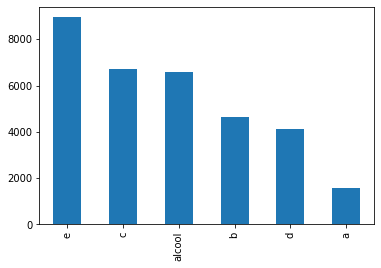

In [ ]:
raw_data['nutrigrade'].value_counts(dropna=False).plot(kind='bar')

In [ ]:
raw_data['nutriscore'] = np.where(raw_data['nutrition-score-fr_100g'].isna() == True, raw_data['nutriscore'], raw_data['nutrition-score-fr_100g'])

In [ ]:
# Drop
raw_data = raw_data.drop(['nutriscore_grade', 'nutrition-score-fr_100g'], axis = 1)

### Marque

De la même manière qu'avec les colonnes relatives à la composante en fruits, on peut compléter certaines valeurs manquantes de la colonne brands par celles de brand_owner.

In [ ]:
print(raw_data['brands'])
print(raw_data['brand_owner'])

1087157                                          NaN
876659                                           NaN
926308                                           NaN
1037715                                          NaN
932384                                           NaN
                             ...                    
721718                      Blédina,Blédilait,Danone
752547                    Gerlinéa,Nutrition & Santé
778909     Agir Carrefour nutrition,Groupe Carrefour
778855     Agir Carrefour nutrition,Groupe Carrefour
752556          Gerlinéa,Mon Repas,Nutrition & Santé
Name: brands, Length: 32566, dtype: object
1087157    NaN
876659     NaN
926308     NaN
1037715    NaN
932384     NaN
          ... 
721718     NaN
752547     NaN
778909     NaN
778855     NaN
752556     NaN
Name: brand_owner, Length: 32566, dtype: object


In [ ]:
# Fill
raw_data['brands'] = raw_data['brands'].fillna(raw_data['brand_owner'])

# drop
raw_data = raw_data.drop(['brand_owner'], axis = 1)

### ecoscore_score_fr et ecoscore_grade_fr

In [ ]:
# Valeurs manquantes
print('nombre de Nans nutriscore_grade :', raw_data['ecoscore_score_fr'].isna().sum())
print('nombre de Nans nutrition-score-fr_100g :', raw_data['ecoscore_grade_fr'].isna().sum())
print('nombre de Nans communs :', np.where((raw_data['ecoscore_score_fr'].isna()) & (raw_data['ecoscore_grade_fr'].isna()), 1, 0).sum())

nombre de Nans nutriscore_grade : 12029
nombre de Nans nutrition-score-fr_100g : 12029
nombre de Nans communs : 12029


Les Nans sont communs aux deux colonnes, on ne peut pas fill l'une avec l'autre. Les variables utilisées pour calculer le score ne sont pas présentes dans le dataset, il est donc impossible de le recalculer.

Je choisi de ne pas imputer les données manquantes.

### Autres fills par 0

In [ ]:
# Autres fills par 0
raw_data['additives_n'] = raw_data['additives_n'].fillna(0)
raw_data['ingredients_from_palm_oil_n'] = raw_data['ingredients_from_palm_oil_n'].fillna(0)
raw_data['ingredients_that_may_be_from_palm_oil_n'] = raw_data['ingredients_that_may_be_from_palm_oil_n'].fillna(0)

# on fill également l'écograde quand il n'est pas reseigné, ainsi que le nova_group
raw_data['ecoscore_grade_fr'] = raw_data['ecoscore_grade_fr'].fillna('inconnu')
raw_data['nova_group'] = raw_data['nova_group'].fillna('inconnu')

## Dernière sélection de colonne et export

On se sépare d'un dernier groupe de colonne avant d'exporter le dataset pour passer à l'analyse exploratoire. il s'agit de colonnes "tags" contenant beaucoup trop de catégories différentes.

In [ ]:
# Drop
raw_data = raw_data.drop(['created_t', 'traces_en', 'additives_en', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags', 'pnns_groups_1', 'main_category_en', 'brands'], axis = 1)

La colonne allergens est difficilement exploitable, on va la transformer en dummy quand il y'a présence d'allergènes dans le produit.

In [ ]:
# Transformation en dummy
raw_data['allergens'] = np.where((raw_data['allergens'].notna() == True), 1, 0)
raw_data['allergens'].sum()

3793

In [ ]:
raw_data = raw_data.reset_index(drop=True)

raw_data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32566 entries, 0 to 32565
Data columns (total 77 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   code                                     32566 non-null  object 
 1   product_name                             32566 non-null  object 
 2   quantity                                 21458 non-null  object 
 3   allergens                                32566 non-null  int64  
 4   additives_n                              32566 non-null  float64
 5   ingredients_from_palm_oil_n              32566 non-null  float64
 6   ingredients_that_may_be_from_palm_oil_n  32566 non-null  float64
 7   nova_group                               32566 non-null  object 
 8   pnns_groups_2                            32566 non-null  object 
 9   ecoscore_score_fr                        20537 non-null  float64
 10  ecoscore_grade_fr                        32566

In [ ]:
# Statistiques sur les nombre de lignes et colonnes à cette étapes du nettoyage
clean_step('sélection finale de colonnes')

,étape,n colonnes,n lignes,% lignes del,% lignes restantes
0,import,187,1998448,0.000000,1.000000
1,filtre sur la France,187,847601,57.587038,42.412962
2,sélection des boissons,187,40114,95.267349,2.007258
3,suppression des colonnes vides,139,40114,0.000000,2.007258
4,suppression des lignes sans nutrition facts,139,34330,14.418906,1.717833
5,suppression des lignes sans nom de produit,139,34160,0.495194,1.709326
6,suppression des doublons,139,32605,4.552108,1.631516
7,suppression des colonnes inutiles ou redondantes,101,32605,0.000000,1.631516
8,suppression des valeurs aberrantes,101,32566,0.119614,1.629565
9,suppression de colonnes inexploitables ou inut...,89,32566,0.000000,1.629565


In [ ]:
# Export en .csv
raw_data.to_csv("/content/drive/MyDrive/PSanté/boissons_nutri.csv", index=False)

Un fichier **Data_Cleaning.py** contenant toutes les opérations de nettoyage inclus dans une fonction est disponible.

